Orbits for all Asteroids in the MPC Database (MPCORB_extended.json.gz).

https://www.minorplanetcenter.net/data 

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from graphviz import Source
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

C:\Users\rrp\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
url = r'C:\Users\rrp\Documents\ox-p4ds\notebooks\Asteroidproject\nea\nea_extended.json'
df = pd.read_json(url,orient = 'columns')

## Feature Analysis

### Attribute Description
To be completed



In [3]:
# Lool for row counts with nullvalues for each column
df.isna().sum()

Aphelion_dist                             0
Arc_length                             6405
Arc_years                             13090
Computer                                  0
Critical_list_numbered_object_flag    18907
Epoch                                     0
G                                         2
H                                         2
Hex_flags                                 0
Last_obs                                  0
M                                         0
NEO_flag                                345
Name                                  19336
Node                                      0
Num_obs                                   0
Num_opps                                  0
Number                                16703
One_km_NEO_flag                       18118
One_opposition_object_flag             7767
Orbit_type                                0
Orbital_period                            0
Other_desigs                          19446
PHA_flag                        

## Asteroid Concentration in different Orbits

In [4]:
#Asteroid concentration in different orbits
orb_astDF = df.groupby(["Orbit_type"])['Ref'].count().reset_index(name = 'Total_Count')
orb_astDF_sorted=orb_astDF.sort_values(['Total_Count'],ascending = True)

In [5]:
#Finding the number of hazardous asteroids in the orbits
phaDF = df.loc[df["PHA_flag"]==1]

orb_phaDF= phaDF.groupby(["Orbit_type"])['Ref'].count().reset_index(name='PHACount')
 
temp=orb_phaDF.merge(orb_astDF,how = 'left', on = 'Orbit_type')
temp.sort_values(['Total_Count'],ascending = False, inplace= True)
temp

,Orbit_type,PHACount,Total_Count
1,Apollo,1592,9781
0,Amor,190,8233
2,Aten,159,1446
3,Object with perihelion distance < 1.665 AU,9,34


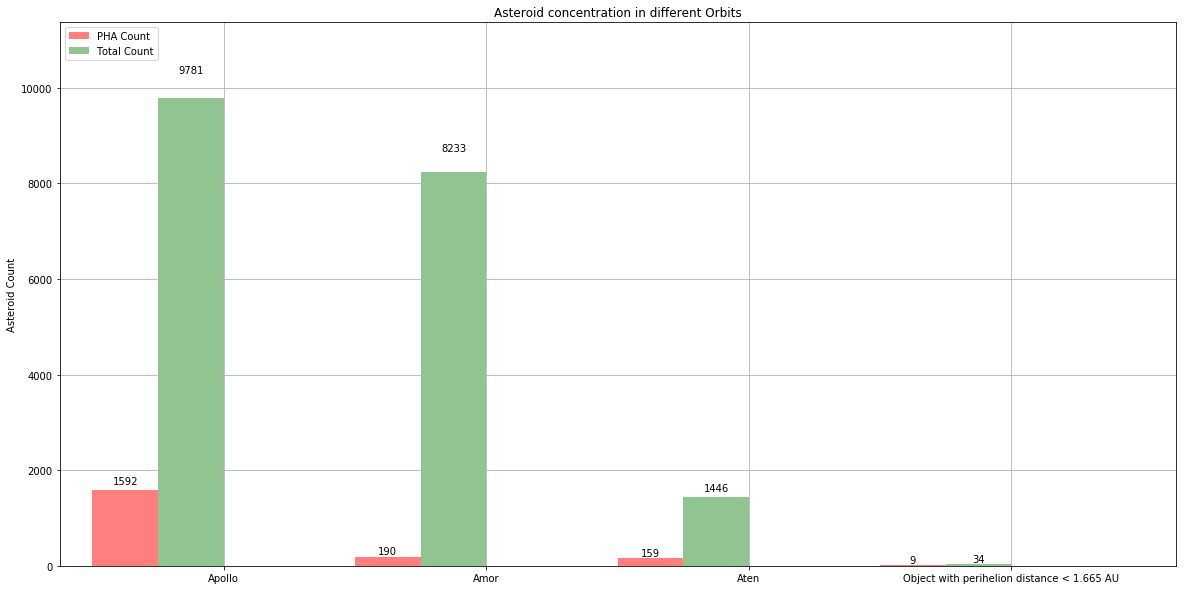

In [6]:
# Setting the positions and width for the bars
pos = list(range(len(temp['PHACount']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with pre_score data,
# in position pos,

bar1 = plt.bar(pos, 
            #using df['pre_score'] data,
            temp['PHACount'], 
            # of width
            width, 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#FF0000', 
            # with label the first value in first_name
            label=temp['Orbit_type'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
bar2 = plt.bar([p + width for p in pos], 
            #using df['mid_score'] data,
            temp['Total_Count'],
            # of width
            width, 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#228b22', 
            # with label the second value in first_name
            label=temp['Orbit_type'][1]) 

# Set the y axis label
ax.set_ylabel('Asteroid Count')

# Set the chart's title
ax.set_title('Asteroid concentration in different Orbits')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(temp['Orbit_type'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(temp['PHACount'] + temp['Total_Count'] )] )

# Adding the legend and showing the plot
plt.legend(['PHA Count', 'Total Count'], loc='upper left')
plt.grid()

def autolabel(bars):
    """
    Attach a text label above each bar displaying its height
    """
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.show()

The results above shows that 'Apollo' tops the list with highest concentration of asteroids. Appollo has got the highest potentially hazardous asteroids too.

In [7]:
#Check if there are any rows with both Arc_years and Arc_length are empty. Per the results, there are no rows with both values empty
Arc_df = pd.DataFrame(df.query("Arc_years== 'NaN' and Arc_length=='NaN'"))
Arc_df

,Aphelion_dist,Arc_length,Arc_years,Computer,Critical_list_numbered_object_flag,Epoch,G,H,Hex_flags,Last_obs,M,NEO_flag,Name,Node,Num_obs,Num_opps,Number,One_km_NEO_flag,One_opposition_object_flag,Orbit_type,Orbital_period,Other_desigs,PHA_flag,Peri,Perihelion_dist,Perturbers,Perturbers_2,Principal_desig,Ref,Semilatus_rectum,Synodic_period,Tp,U,a,e,i,n,rms


#### After looking at the data, my observation on some fields are as below:

Columns that can be dropped:
Computer - I beleive it is the name of the computer which has provided the information, not a required field,hence can be omitted.
Hex flag - this column can be dropped out, as the values are decoded and given as independent columns.

Name,Number,Other_desigs - Change value to '0', if absent.
Critical list numbered object flag - if value is absent, set it to 0
NEO_flag - if value is absent, set it to 0
One_km_NEO_flag - if value is absent, set it to 0
PHA_flag - if value is absent, set it to 0
One_opposition_object_flag - if value is absent, set it to 0


Arc_years - Only present for multi-opposition orbits .
Arc_length - Only present for single opposition orbits. There are no rows with both values as 'NaN'.

'G' and 'H' - We can drop rows that has NaN values for both 'G' and 'H'. The rows with NaN values are negligible compared to the total rows.


In [8]:
#Dropping columns
df= df.drop(['Computer','Hex_flags','Name','Number','Other_desigs'],axis= 1)


In [9]:
#Changing NaN values for flags  to 0
df['Critical_list_numbered_object_flag'].fillna(0,inplace = True)
df['NEO_flag'].fillna(0,inplace = True)
df['One_km_NEO_flag'].fillna(0,inplace = True)
df['PHA_flag'].fillna(0,inplace = True)
df['One_opposition_object_flag'].fillna(0,inplace = True)
df['Num_obs'].fillna(0,inplace = True)

#Drop rows with NaN values for G and H
#df.dropna(subset=['G','H'], how = 'all',inplace = True)
#Drop rows with NaN values for U
df.dropna(subset=['U'],inplace = True)

In [10]:
df.isna().sum()

Aphelion_dist                             0
Arc_length                             6405
Arc_years                             13070
Critical_list_numbered_object_flag        0
Epoch                                     0
G                                         2
H                                         2
Last_obs                                  0
M                                         0
NEO_flag                                  0
Node                                      0
Num_obs                                   0
Num_opps                                  0
One_km_NEO_flag                           0
One_opposition_object_flag                0
Orbit_type                                0
Orbital_period                            0
PHA_flag                                  0
Peri                                      0
Perihelion_dist                           0
Perturbers                               15
Perturbers_2                             15
Principal_desig                 

### Find Asteroids which are closer to Sun(low perihelion distance)

## Relation between Eccentricity and Semi Major axis

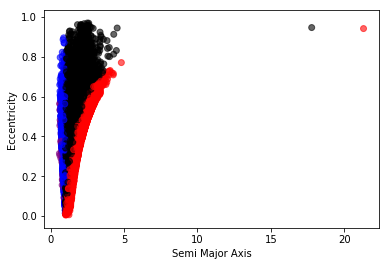

In [11]:
# Semi Major axis - Object's distance from the sun.
#Eccentricty - describes the orbit shape

colors = {"Amor": "red", 
               "Apollo": "black",
               "Aten" : "blue",
              "Object with perihelion distance < 1.665 AU" : "purple",
              "Atira" : "yellow"
               }
plt.xlabel('Semi Major Axis')
plt.ylabel('Eccentricity')

plt.scatter(df['a'],df['e'],c=df["Orbit_type"].apply(lambda x: colors[x]),  alpha=0.6)
plt.show()

As we can see above, asteroids in 'Atira' orbits has a very higher SMA and eccentricity. High eccentricity means the orbit is more parabolical in shape. Let us remove asteroids in 'Atira' from the dataframe to get a closer relationship between SMA and eccentricity.

In [12]:
NoAtira_df =  df.loc[df["Orbit_type"]!='Atira']
df.loc[df["a"]>5]

,Aphelion_dist,Arc_length,Arc_years,Critical_list_numbered_object_flag,Epoch,G,H,Last_obs,M,NEO_flag,Node,Num_obs,Num_opps,One_km_NEO_flag,One_opposition_object_flag,Orbit_type,Orbital_period,PHA_flag,Peri,Perihelion_dist,Perturbers,Perturbers_2,Principal_desig,Ref,Semilatus_rectum,Synodic_period,Tp,U,a,e,i,n,rms
1147,34.623418,88.0,NaN,0.0,2458600.5,0.15,17.2,2000-02-28,93.87078,1.0,49.29225,206,1,1.0,1.0,Apollo,75.013291,1.0,332.81608,0.949717,M-v,3Eh,1999 XS35,MPC 39559,0.924362,1.013511,2.451456e+06,2,17.786568,0.946605,19.37662,0.013139,0.52
9339,41.395109,77.0,NaN,0.0,2458600.5,0.15,20.0,2014-10-21,17.50740,1.0,338.57349,105,1,0.0,1.0,Amor,98.448597,0.0,311.47474,1.246772,M-v,38h,2014 PP69,MPO342302,1.210319,1.010262,2.456852e+06,1,21.320940,0.941524,93.65214,0.010011,0.38


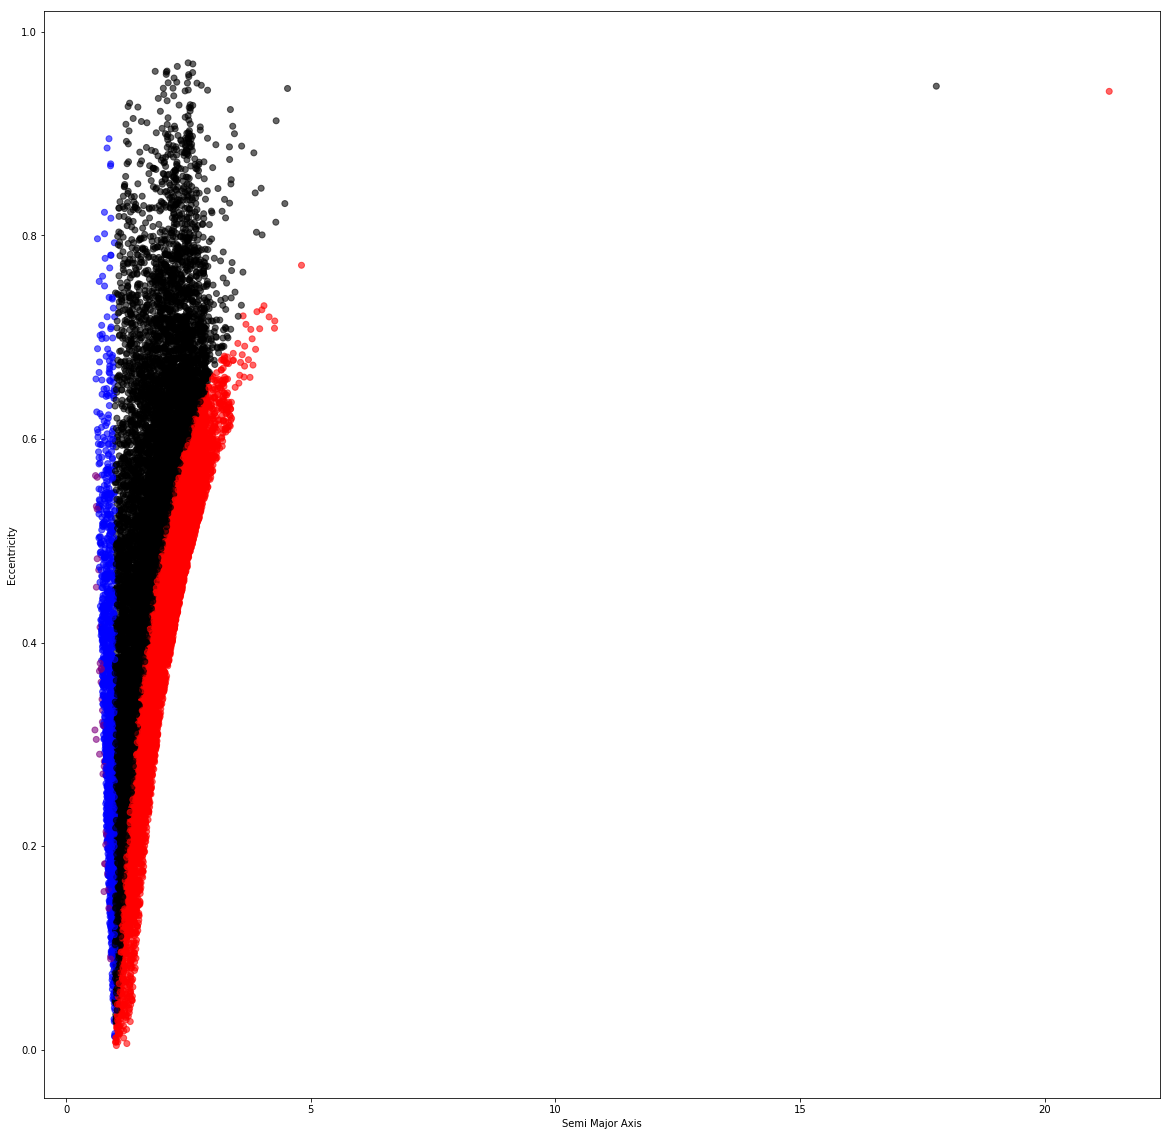

In [13]:

plt.figure(figsize=(20, 20))
plt.scatter(NoAtira_df['a'],NoAtira_df['e'],c=NoAtira_df["Orbit_type"].apply(lambda x: colors[x]), alpha=0.6)
plt.xlabel('Semi Major Axis')
plt.ylabel('Eccentricity')
plt.show()

In [14]:
#As we see above, there is a clear distinction between different orbit types.

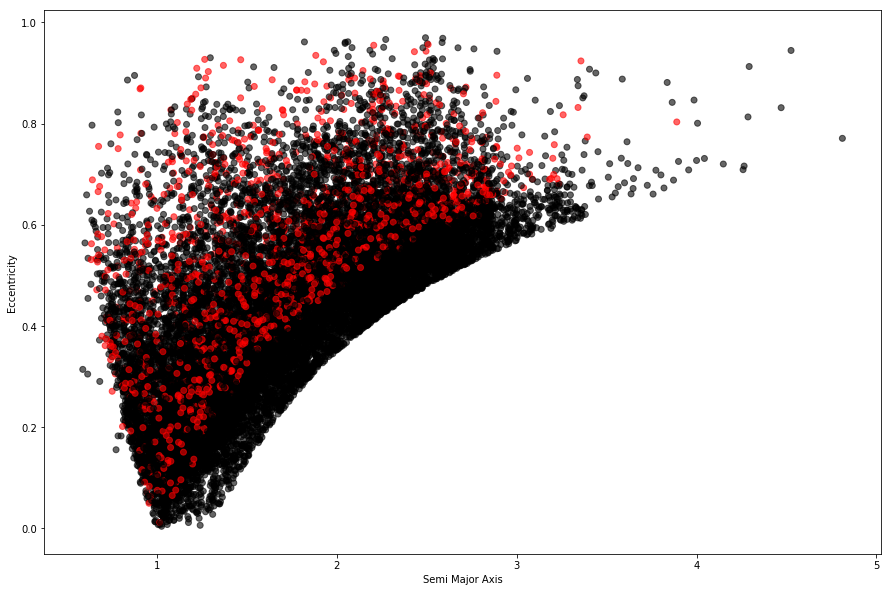

In [15]:
#Let us look at the above relation for PHA and non-PHA
NoAtira_df1 = NoAtira_df.loc[(NoAtira_df["a"]<=5)]
colors = {1.0: "red", 
               0: "black",
               }
plt.figure(figsize=(15, 10))
plt.scatter(NoAtira_df1['a'],NoAtira_df1['e'],c=NoAtira_df1["PHA_flag"].apply(lambda x: colors[x]), alpha=0.6)
plt.xlabel('Semi Major Axis')
plt.ylabel('Eccentricity')
plt.show()



As we can see above, semi major axis is lesser for PHA compared to non-PHA's 

### Semi Major Axis and Eccentricity

In [16]:
#There is a moderately strong correlation between Semi Major axis and eccentricity . THere are outliers which has got SMA greater than 4AU.
#Let us look closely at asteroids with SMA < 4AU
#PHA asteroids
NoAtira_phadf = NoAtira_df.loc[(NoAtira_df["PHA_flag"] == 1.0) & (NoAtira_df["a"]<=5)]
#Non-PHA Asteroids
NoAtira_nphadf = NoAtira_df.loc[(NoAtira_df["PHA_flag"] == 0) & (NoAtira_df["a"]<=5)]

#We can use the LinerarRegression model from the sklearn Python package to build a linear regression model. First we fit the data. This trains the model based on the two variables, in this case n-PHA asteroids: eccentricity and PHA asteroids:mean daily motion
#This is for non-PHA asteroids.
lm_npha = linear_model.LinearRegression()
lm_npha.fit([[x] for x in NoAtira_nphadf.a], NoAtira_nphadf.e)
m = lm_npha.coef_[0]
b = lm_npha.intercept_
print("slope=", m, "intercept=", b)

slope= 0.20777472354040627 intercept= 0.06855619368412952


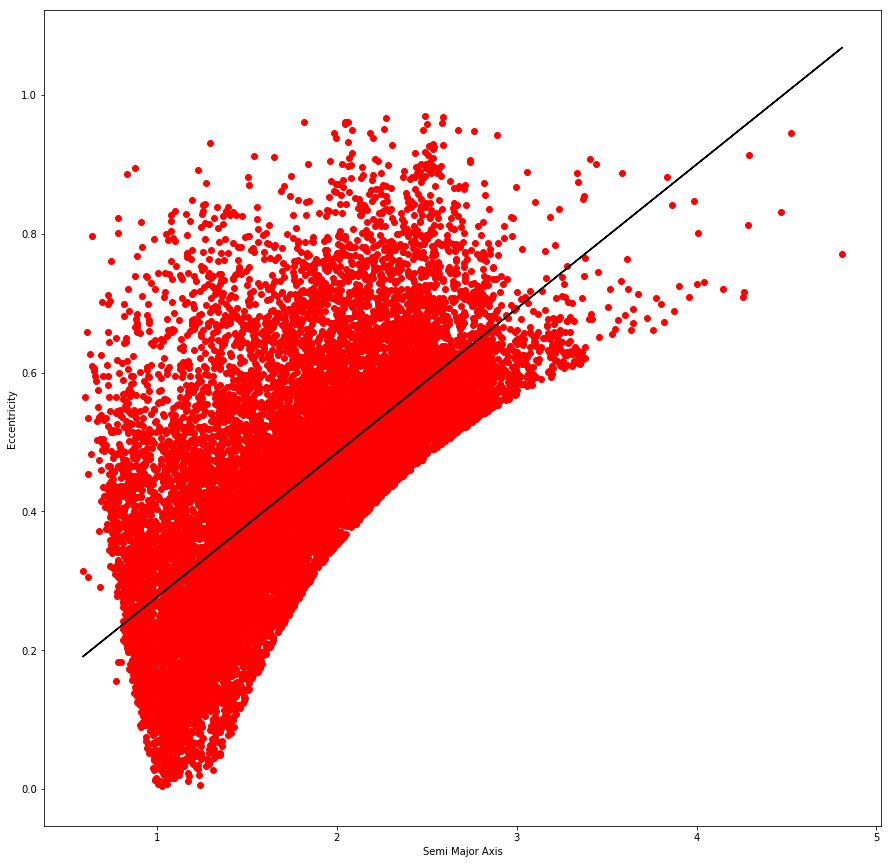

In [17]:
#To see how the linear model we trained on the PHA semimajor axis and eccentricity, we can plot the linear relationship over our scattergraph using the slope and intercept we extracted from our linear model lm_pha: 

plt.figure(figsize=(15, 15))
plt.scatter(x=NoAtira_nphadf.a, y=NoAtira_nphadf.e, c='red')
predicted_values_m = [lm_npha.coef_ * i + lm_npha.intercept_ for i in NoAtira_nphadf.a]

plt.xlabel("Semi Major Axis")
plt.ylabel("Eccentricity")

plt.plot(NoAtira_nphadf.a, predicted_values_m, 'black')


In [18]:
#Now we can use the above model to predict the values of 'e'.
#For semimajoraxis 3.517355, the eccentricity can be predicted as below.
p_e_npha = lm_npha.predict([[3.517355]])  
p_e_npha

array([0.79937366])

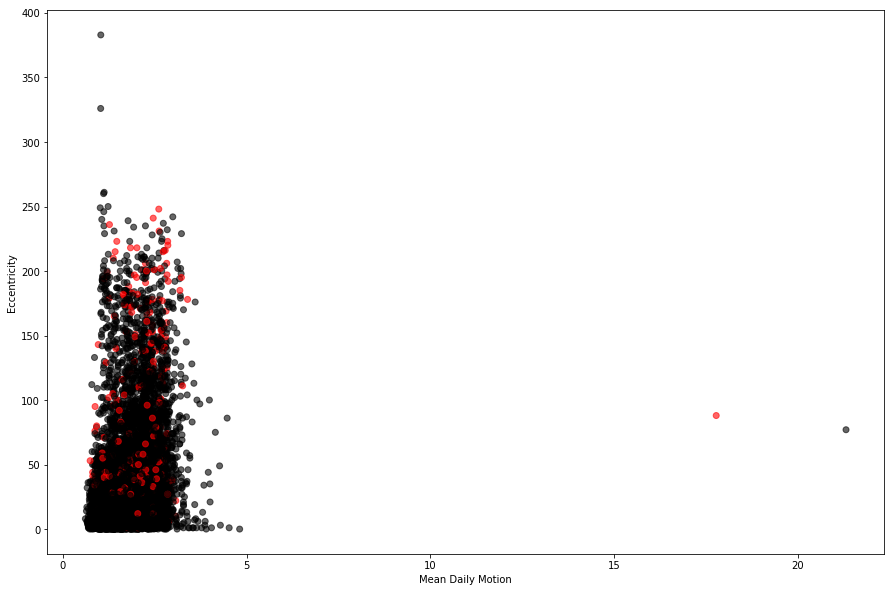

In [19]:
#Let us look at eccentricity and mean dailymotion(n) relation for PHA and non-PHA
colors = {1.0: "red", 
               0: "black",
               }
plt.figure(figsize=(15, 10))
plt.scatter(NoAtira_df['a'],NoAtira_df['Arc_length'],c=NoAtira_df["PHA_flag"].apply(lambda x: colors[x]), alpha=0.6)

plt.xlabel('Mean Daily Motion')
plt.ylabel('Eccentricity')
plt.show()

### Eccentricity and Mean Daily Motion

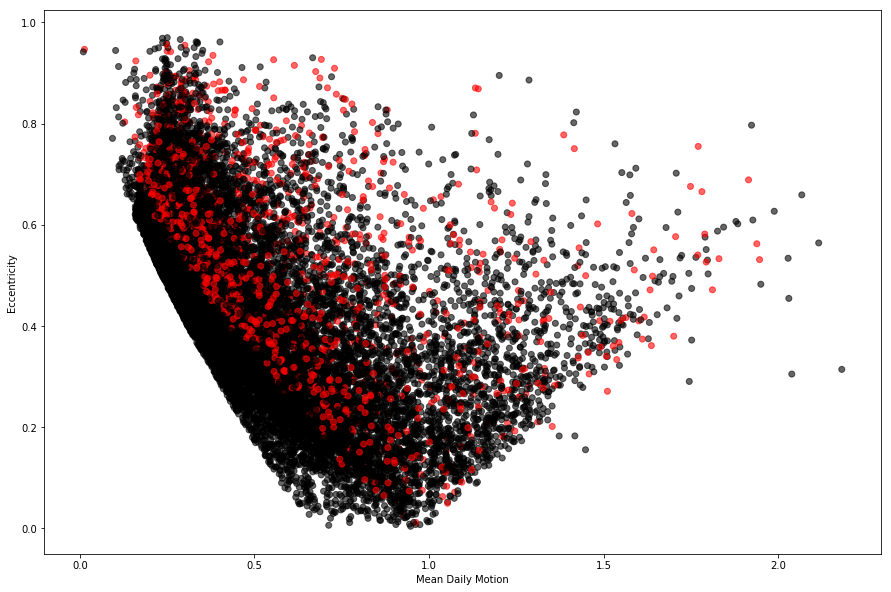

In [20]:
#Let us look at eccentricity and mean dailymotion(n) relation for PHA and non-PHA
colors = {1.0: "red", 
               0: "black",
               }
plt.figure(figsize=(15, 10))
plt.scatter(NoAtira_df['n'],NoAtira_df['e'],c=NoAtira_df["PHA_flag"].apply(lambda x: colors[x]), alpha=0.6)

plt.xlabel('Mean Daily Motion')
plt.ylabel('Eccentricity')
plt.show()

There is a moderately strong negative~ correlation between eccentricity and Mean Daily motion. Asteroids with more dailymean motion has more of a circular orbit. Seems that PHA asteroids with same eccentricity as non-PHA  has dailymean motion more compared to the non-PHA asteroids. There are outliers here, which are either PHA or non-PHA. Lets see below which orbit types they belongs to.

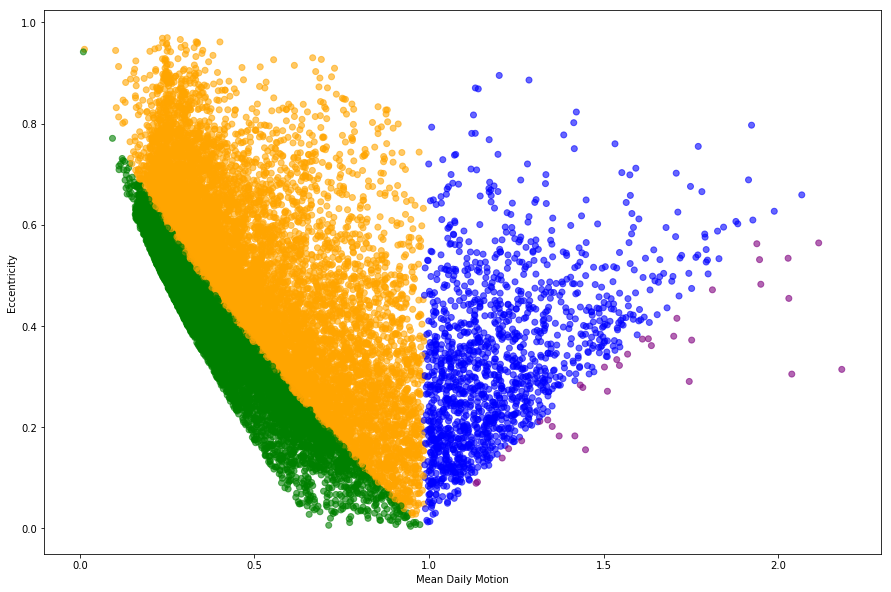

In [21]:
colors = {"Amor": "green", 
               "Apollo": "orange",
               "Aten" : "blue",
              "Object with perihelion distance < 1.665 AU" : "purple",
              "Atira" : "black"
               }

plt.figure(figsize=(15, 10))
#colors = df["Orbit_type"].map(lambda x: color_wheel.get(x))
plt.scatter(NoAtira_df['n'],NoAtira_df['e'],c=NoAtira_df["Orbit_type"].apply(lambda x: colors[x]),  alpha=0.6)
plt.xlabel('Mean Daily Motion')
plt.ylabel('Eccentricity')
plt.show()

As we see above the outliers mostly belongs to 'Aten' and 'Object with perihelion distance less thatn 1.665AU'.
The mean daily motion forthose orbits starts at aminimum around 1.0 degrees perday.
Asteroids in 'Amor' are mostly non hazardous.
There is a moderately strong negative correlation exisitng in Amor and Apollo.
Whereas there a positive correlation that exists with Aten and Object with perihelion distance less thatn 1.665AU

### Decision Trees 

In [22]:
#Decision trees require  allfeatures  to be in numericalvalues.

#Mapping orbit types to numerical
df['Orbit_type_map'] = df['Orbit_type'].map({'Apollo': 1, 'Amor': 2,'Atira' :3,'Aten':4,'Object with perihelion distance < 1.665 AU':5})
PCA_df = df

PCA_df= PCA_df.drop(['Orbit_type','Ref','Perturbers','Perturbers_2','Arc_years','Arc_length','Principal_desig','Last_obs','U'],axis= 1)
#PCA_df= PCA_df.drop(['Orbit_type','Ref','Perturbers','Perturbers_2','Principal_desig','Last_obs','U'],axis= 1)

PCA_df = PCA_df.dropna(subset=['G'])
PCA_df = PCA_df.dropna(subset=['H'])
PCA_df= PCA_df.drop(['Critical_list_numbered_object_flag'],axis=1)
#It is not correct tomap orbit types to numbers, better get away with the column
PCA_df= PCA_df.drop(['Orbit_type_map'],axis=1)



### Decision trees without PCA

In [23]:
#Decision Trees without PCA

X = PCA_df.drop('PHA_flag',1)   #All columns without PHA_flag
y = PCA_df['PHA_flag']          #Only PHA_flag(this is the column to be predicted)

#Divide data into traning and data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

classifier = DecisionTreeClassifier(max_depth=4)
classifier.fit(X_train.values, y_train.values)

#Now we have a model trained using X_train and y_train. Let us take the test datasest X_test.
sample = X_test

#The following line will predict the PHA_flag for the test dataset and the predicted value is stored in sample['PHA_flag']
predictions = classifier.predict(sample)
sample['PHA_flag'] = predictions

In [24]:
#Applying this on to the test dataset, it looks like the model is 92% accurate
accuracy_score(y_test, predictions)

0.9213390840008215

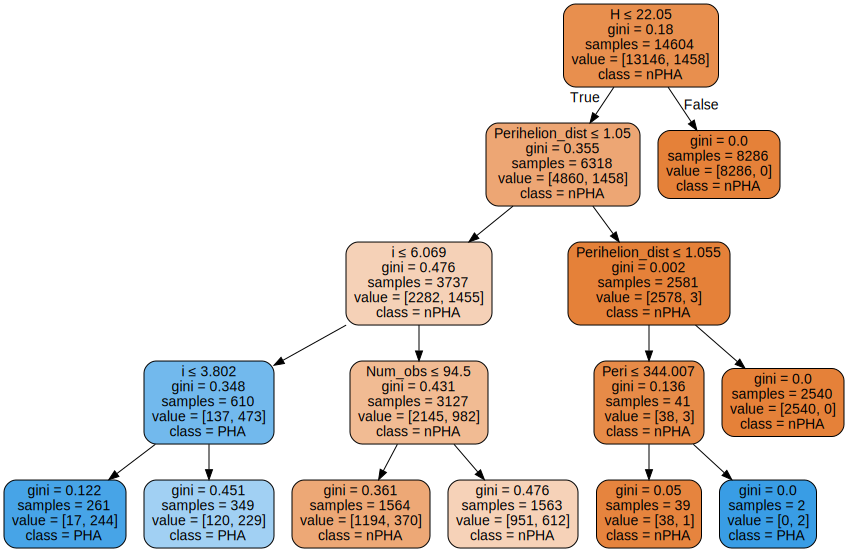

In [25]:
#Decision Trees
tree_plot = Source(tree.export_graphviz(classifier, out_file=None, 
                            feature_names=X_train.columns, class_names=['nPHA', 'PHA'], 
                            filled=True, rounded=True, special_characters=True))
tree_plot

In [26]:
rank = np.argsort(classifier.feature_importances_)[::-1]
#first mostimportant features
print(rank[:5])
#print(X_train.get_feature_names()[rank[:5]])
#print('\n'.join(X_train.get_feature_names()[i] for i in rank[:5]))
#print(sorted(list(zip(classifier.feature_importances_, X_train.get_feature_names()))))
print(dict(zip(X_train.columns, classifier.feature_importances_)))


[13  3 19  7 12]
{'Aphelion_dist': 0.0, 'Epoch': 0.0, 'G': 0.0, 'H': 0.3396837343619702, 'M': 0.0, 'NEO_flag': 0.0, 'Node': 0.0, 'Num_obs': 0.03341146639760868, 'Num_opps': 0.0, 'One_km_NEO_flag': 0.0, 'One_opposition_object_flag': 0.0, 'Orbital_period': 0.0, 'Peri': 0.0032137711324134693, 'Perihelion_dist': 0.40972099348567603, 'Semilatus_rectum': 0.0, 'Synodic_period': 0.0, 'Tp': 0.0, 'a': 0.0, 'e': 0.0, 'i': 0.21397003462233163, 'n': 0.0, 'rms': 0.0}


In [27]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869 entries, 14679 to 5968
Data columns (total 23 columns):
Aphelion_dist                 4869 non-null float64
Epoch                         4869 non-null float64
G                             4869 non-null float64
H                             4869 non-null float64
M                             4869 non-null float64
NEO_flag                      4869 non-null float64
Node                          4869 non-null float64
Num_obs                       4869 non-null int64
Num_opps                      4869 non-null int64
One_km_NEO_flag               4869 non-null float64
One_opposition_object_flag    4869 non-null float64
Orbital_period                4869 non-null float64
Peri                          4869 non-null float64
Perihelion_dist               4869 non-null float64
Semilatus_rectum              4869 non-null float64
Synodic_period                4869 non-null float64
Tp                            4869 non-null float64
a        

## Applying Dimenstion Reduction (PCA)

In [28]:
##Steps to apply PCA

Xp = PCA_df.drop('PHA_flag',1)
yp = PCA_df['PHA_flag']

#Divide data into traning and data sets
X_trainp, X_testp, y_trainp, y_testp = train_test_split(Xp, yp, test_size=0.2,random_state=0) 

# PCA performs best with a normalized feature set. Will perform standard scalar normalization to normalize our feature set.
sc = StandardScaler()  
X_trainp = sc.fit_transform(X_trainp)  
X_testp = sc.transform(X_testp)

#Now Applying PCA.
#Not specifying the number of components in the PCA constructor. Hence, all features in the feature set will be returned for both the training and test sets.
pca = PCA()  
X_trainpca = pca.fit_transform(X_trainp)  
X_testpca = pca.transform(X_testp)

#Find the variance caused by each of the principal components. 
explained_variance = pca.explained_variance_ratio_ 

print(explained_variance)

[2.30448507e-01 1.47134847e-01 8.31362868e-02 6.67929326e-02
 5.33366765e-02 4.70760634e-02 4.62604900e-02 4.60740579e-02
 4.49835850e-02 4.42223641e-02 4.35104531e-02 4.10875760e-02
 2.93844192e-02 2.43538133e-02 2.05524897e-02 1.17182217e-02
 9.49573050e-03 6.93838734e-03 3.25585271e-03 2.10293832e-04
 2.69522136e-05 1.54321071e-32]


Lets explore the above variance results.
The first principal component is responsible for 21% variance.

Second component causes 13.7% variance,Third causes 7% variance,Fourth causes 6% variance.


### Decision Trees with PCA

In [29]:
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X_trainpca, y_trainp)

#Now we have a model trained using X_train and y_train. Let us take the test datasest X_test.
sample = X_testpca

#The following line will predict the PHA_flag for the test dataset and the predicted value is stored in sample['PHA_flag']
predictions = classifier.predict(sample)

#Applying this on to the test dataset, it looks like the model is 89% accurate
accuracy_score(y_testp, predictions)



0.8939666238767651

In [30]:
#Accuracy score is 89% which is less than that without PCA.